In [214]:
# Variáveis Iniciais do Sistema
initial_date = "01-01-2020"
final_date = "01-01-2020"
total_registers = 900
total_users = 1200

# Regioes e Locais cadastrados no sistemas de SmartParking
parkings_data = [
    {
        "parking": "IPB",
        "regions": [
            {
                "name": "ipb-cantina",
                "open_time": "08:00",
                "close_time": "20:00",
                "max_slots": 300,
                "ocuppation_avg": 0.4,
                "parking_time_min": 15,
                "parking_time_average": 60,
                
                "weekday_flow": 1.0,
                "weekend_flow": 0.5,
                
                "rainy flow": 0.7,
                "sunny flow": 1.0,
                "weather_rain_chance": 0.05,
                
                "parking_time_max": 300,
                "variation": 0.8,
                "rush_range": [
                    {
                        "start": "12:00",
                        "finish": "14:00",
                        "increase": 2.5
                    },
                    {
                        "start": "18:00",
                        "finish": "19:00",
                        "increase": 1.8
                    }
                ]
            }
        ]
    }
]

In [215]:
# Importações de Bibliotecas Necessárias
import pandas as pd
import numpy as np
import time

from datetime import datetime
from datetime import timedelta  

from random import seed
from random import randint

from matplotlib import pyplot as plt
import matplotlib.dates as md

In [216]:
cols = ["parking","region","timeFrom","timeTo","weekday","spotWanted","spotWon"]

date = datetime.strptime(initial_date, '%d-%m-%Y')
end_date = datetime.strptime(final_date, '%d-%m-%Y')

for park in parkings_data:
    for region in park['regions']:
        region['open_time'] = datetime.strptime(region['open_time'], '%H:%M').time()
        region['close_time'] = datetime.strptime(region['close_time'], '%H:%M').time()
        for rush in region['rush_range']:
            rush['start'] = datetime.strptime(rush['start'], '%H:%M').time()
            rush['finish'] = datetime.strptime(rush['finish'], '%H:%M').time()

print("Start Generating On:", date.strftime('%d-%m-%Y'))
print("Finish Generating On:", end_date.strftime('%d-%m-%Y'))
days_total = (end_date - date).days
print("Total Days: ", days_total)

Start Generating On: 01-01-2020
Finish Generating On: 01-01-2020
Total Days:  0


In [221]:
df = pd.DataFrame(columns=cols)

start_time = time.time()
print("Generating Data...\n")

# Zera a lista do estacionamento
parkings = []

# Verifica se o horario atual é um horário de maior fluxo para aquela região    
def is_rush_time(region):
    is_rush = False
    rush_increase = 1
    for rush in region['rush_range']:
        if (date.time() >= rush['start'] and date.time() <= rush['finish']):
            is_rush = True
            rush_increase = rush['increase']
        # Increase Some More Parkings When Nearing to the rush time and Increase Some Parkings time after the end rush's time
        #else if (date.time())
    return is_rush, rush_increase

# Define quantos parkings serao criados em cada execucao dependendo se a regiao esta ou nao em horario de maior fluxo
def add_parkings_by_rush(region):
    is_rush, rush_increase = is_rush_time(region)
    
    add_parkings = randint(1,24)
    if (is_rush):
        # Multiplicacao do anterior OU randint(1,3*increase) *****************
        add_parkings = add_parkings * rush_increase
        #add_parkings = randint(1,int(3*rush_increase))
        
    return add_parkings

# Verifica se é dia de semana / final de semana
def check_weekday(date):
    day = date.strftime('%A')
    if day == "Saturday" or day == "Sunday":
        return 0
    return 1

# Percorre cada Parking cadastrado
for park in parkings_data:
    var_parking = park['parking']
    print("Generating Data for Parking: ",var_parking)
    # Percorre cada Região do parking
    for region in park['regions']:
        var_region = region['name']
        print("\tGenerating Data for Region: ",var_region, " ...")
        
        # Obtem os horarios de abertura e fechamento da Região do Parking
        open_time = region['open_time']
        close_time = region['close_time']
        
        # Obtem o tempo minimo e maximo de estacionamentos no local
        parking_time_min = region['parking_time_min']
        parking_time_max = region['parking_time_max']
        parking_time_average = region['parking_time_average']
        if (parking_time_min == None):
            parking_time_min = 15
        if (parking_time_max == None):
            parking_time_max = 300
        if (parking_time_average == None):
            parking_time_average = 60
            
        # Zera lista de spots ocupados no estacionamento
        parking_spots = []
        parking_max_slots = region['max_slots']
        parking_empty_slots = parking_max_slots
        
        for c in range(parking_max_slots):
            parking_spots.append(None)
        
        # Zera a data de inicio e fim para iniciar a criacao de dados
        date = datetime.strptime(initial_date, '%d-%m-%Y')
        date = date.replace(hour=open_time.hour, minute=open_time.minute)
        
        end_date = datetime.strptime(final_date, '%d-%m-%Y')
        end_date = end_date.replace(hour=close_time.hour, minute=close_time.minute)  
        
        rushs = 0
        notrushs = 0
        
        weekday_flow = region['weekday_flow']
        weekend_flow = region['weekend_flow']
        
        while(date <= end_date):
            
            add_parkings = add_parkings_by_rush(region)
            
            # Insere estacionamentos na base de dados
            while (add_parkings > 0):
                
                # Chance do estaciomamento durar: [ Ate 60min : 70%  | Acima de 60min: 30% ]
                parking_time = randint(parking_time_min,parking_time_average)
                if (randint(1,10) > 5):
                    parking_time = randint(parking_time_average,parking_time_max)
                
                # Cria uma ROW
                row = {'parking': var_parking, 'region': var_region}
                row.update({'timeFrom': date.strftime('%d-%m-%Y %H:%M')})
                
                # Adiciona o Role ***********************************************
                validate_date = date + timedelta(minutes=parking_time)

                if (validate_date.hour >= close_time.hour and validate_date.minute >= close_time.minute):                   
                    row.update({'timeTo': (date.replace(hour=close_time.hour, minute=close_time.minute).strftime('%d-%m-%Y %H:%M')) })
                elif (validate_date.hour < open_time.hour):
                    row.update({'timeTo': (date.replace(hour=close_time.hour, minute=close_time.minute).strftime('%d-%m-%Y %H:%M')) })
                else:
                    row.update({'timeTo': validate_date.strftime('%d-%m-%Y %H:%M')})
                
                # Adiciona Horas no sistema
                check_rush,rush_increase = is_rush_time(region)
                addMin = randint(1, 5)
                
                # Inicia em 100% a chance de adicionar mais horas (quanto menor o percentual mais estacioamentos serao realizados)
                addPercent = 0
                
                # [Variaveis de Padronizacao] Calcula Impacto de horarios de alto fluxo (Rush Hours)
                if (check_rush):
                    addMin = randint(1, int(5 / rush_increase))
                    addPercent = addPercent + 75
                    
                # [Variaveis de Padronizacao] Calcula Impacto do Fim de Semana (WeekDays/WeekendDays)
                is_weekday = check_weekday(date)
                row.update({'weekday': is_weekday})
                
                if (is_weekday == 1):
                    addPercent = int(addPercent * weekday_flow)                
                else:
                    addPercent = int(addPercent * weekend_flow)
                    
                # [Variaveis de Padronizacao] Calcula Impacto do Clima Atual (Rainy/Sunny)
                
                
                # [Variaveis de Padronizacao] Calcula o Impacto de Feriados (Holidays)
                
                    
                # ***********************************************************************************
                
                # [SPOT NUMBER] Encontra um SpotID vago para o usuario
                spot_found = False
                spot_id = -1
                
                # Define aleatoriamente um Spot de vaga "Desejado" pelo Usuario
                try_spot = randint(0,parking_max_slots-1)
                row.update({'spotWanted': try_spot})
                
                # Tenta encontrar em um spot disponivel de forma aleatoria por 10 tentativas
                for c in range(1,10):
                    if (parking_spots[try_spot] == None):
                        spot_found = True
                        spot_id = try_spot
                        parking_spots[spot_id] = datetime.strptime(row['timeTo'], '%d-%m-%Y %H:%M')
                        break
                    try_spot = randint(0,parking_max_slots-1)
                
                # Caso nao encontre em 10 tentativas aleatorias -> seleciona o primeiro disponivel em ordem crescente
                if not (spot_found):
                    for c in range(len(parking_spots)):
                        if (parking_spots[c] == None):
                            spot_id = c
                            parking_spots[spot_id] = datetime.strptime(row['timeTo'], '%d-%m-%Y %H:%M')
                            break
                
                row.update({'spotWon': spot_id}) 

                # Finaliza o Role ***********************************************                
                parkings.append(row)
                
                addChance = randint(0,100)
                    
                if (addChance >= addPercent):
                    date = date + timedelta(minutes=addMin)
                
                # Verifica se a nova hora e data é valida
                if not(date.time() >= open_time and date.time() <= close_time):
                    date = date + timedelta(days=1)
                    date = date.replace(hour=open_time.hour, minute=open_time.minute)
                    
                if (date >= end_date):
                    break
                    
                # Libera Espacos vagos no estacionamento
                for c in range(len(parking_spots)):
                    if (parking_spots[c] != None):
                        if (parking_spots[c] <= date):
                            parking_spots[c] = None
                        
                add_parkings -= 1
                    
    print("\n")
    
end_time = time.time()
final_time = datetime.fromtimestamp((end_time-start_time))
final_time = final_time.replace(microsecond=0)
df = df.append(parkings, ignore_index=True)
print("\nTime Spent: ",final_time.time())
print("Done!")

Generating Data...

Generating Data for Parking:  IPB
	Generating Data for Region:  ipb-cantina  ...



Time Spent:  00:00:00
Done!


In [222]:
parking_spots

[None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 None,
 None,
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 datetime.datetime(2020, 1, 1, 20, 0),
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 datetime.datetime(2020, 1, 1, 20, 0),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 Non

In [75]:
print("Writing output file...")
df.to_csv('generated_dataset_v3.csv', index=False)
print("Done!")

Writing output file...
Done!


In [76]:
print("Reading CSV...")
df = pd.read_csv('generated_dataset_v3.csv')
#df = df.drop('timeTo',axis=1)

print("Setting the Pattern in DateTime Columns...")
df['timeFrom'] = pd.to_datetime(df['timeFrom'], errors='ignore')
df['timeFrom'] = pd.to_datetime(df["timeFrom"].dt.strftime('%d-%m-%Y %H:%M'))

print("Done!")

df

Reading CSV...
Setting the Pattern in DateTime Columns...
Done!


,parking,region,timeFrom,timeTo,weekday
0,IPB,ipb-cantina,2020-01-01 08:00:00,01-01-2020 10:21,1
1,IPB,ipb-cantina,2020-01-01 08:02:00,01-01-2020 12:27,1
2,IPB,ipb-cantina,2020-01-01 08:03:00,01-01-2020 08:31,1
3,IPB,ipb-cantina,2020-01-01 08:04:00,01-01-2020 08:59,1
4,IPB,ipb-cantina,2020-01-01 08:08:00,01-01-2020 11:38,1
...,...,...,...,...,...
13290,IPB,ipb-cantina,2020-01-30 19:48:00,30-01-2020 20:00,1
13291,IPB,ipb-cantina,2020-01-30 19:49:00,30-01-2020 20:00,1
13292,IPB,ipb-cantina,2020-01-30 19:51:00,30-01-2020 20:00,1
13293,IPB,ipb-cantina,2020-01-30 19:55:00,30-01-2020 20:00,1


In [77]:
df1 = df.copy()
df1 = df1[['timeFrom','weekday']]

print("Setting the Pattern in DateTime Columns...")
df1['timeFrom'] = pd.to_datetime(df1['timeFrom'], errors='ignore')

print("Grouping by Day...")
df1 = df1.groupby(df1['timeFrom'].dt.date).size().reset_index(name='TotalParkings')

print("Done!")
df1

Setting the Pattern in DateTime Columns...
Grouping by Day...
Done!


,timeFrom,TotalParkings
0,2020-01-01,431
1,2020-01-02,505
2,2020-01-03,487
3,2020-01-04,358
4,2020-01-05,348
5,2020-01-06,515
6,2020-01-07,460
7,2020-01-08,516
8,2020-01-09,461
9,2020-01-10,448


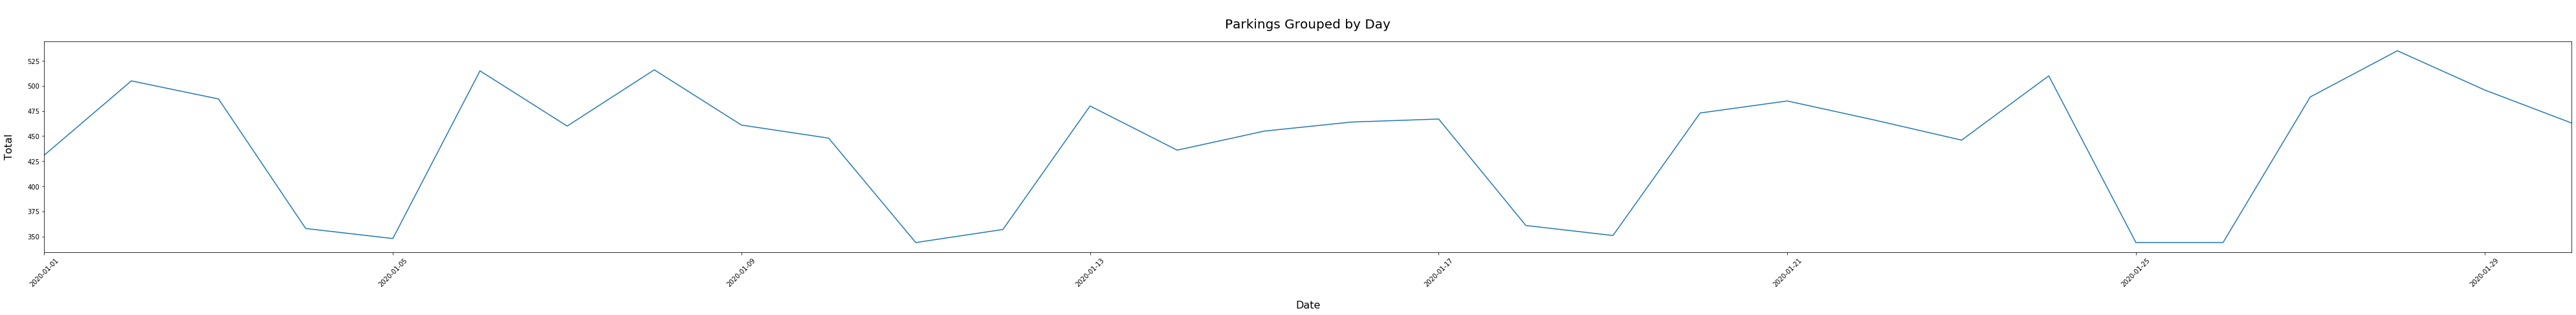

In [78]:
df3 = df1.copy()
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(70,6))
plt.title("\nParkings Grouped by Day", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)
plt.xticks(rotation=45)
plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.plot(df3)

In [79]:
df2 = df1.copy()
print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
df2 = df2.groupby(pd.Grouper(freq='M', key='timeFrom')).sum().reset_index()
df2['timeFrom'] = df2['timeFrom'].dt.strftime('%m-%Y')

print("Done!")
df2

Setting the Pattern in DateTime Columns...
Grouping by Month
Done!


,timeFrom,TotalParkings
0,01-2020,13295


Grouping by Month


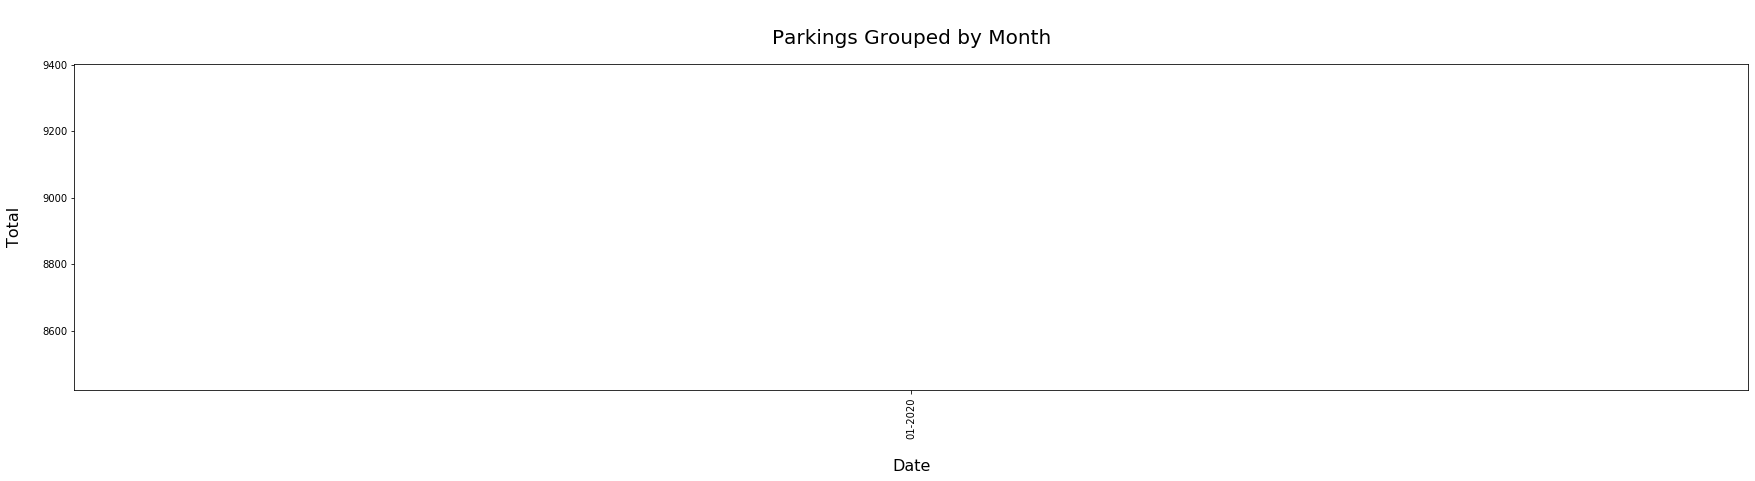

In [66]:
df3 = df2.copy()

print("Grouping by Month")
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(30,6))
plt.title("\nTotal: "+str(len(df['timeTo'])), fontsize=30, pad=20)
plt.title("\nParkings Grouped by Month", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)

plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.xticks(rotation=90)

plt.plot(df3)

Setting the Pattern in DateTime Columns...
Setting Query for Specific Day and Month...
Generating Graph...


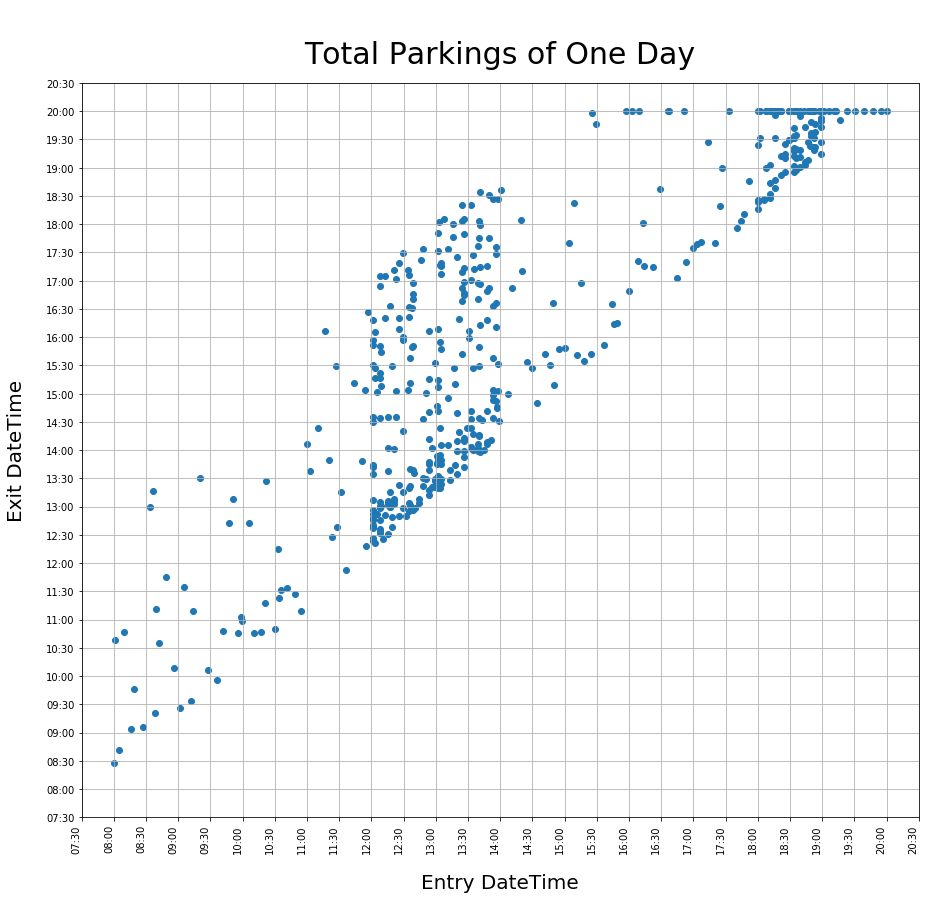

In [38]:
df4 = df.copy()
df4 = df4[['timeFrom','timeTo']]

print("Setting the Pattern in DateTime Columns...")
df4['timeFrom'] = pd.to_datetime(df4['timeFrom'], errors='ignore')
df4['timeFrom'] = pd.to_datetime(df4["timeFrom"].dt.strftime('%d/%m/%Y %H:%M'))

df4['timeTo'] = pd.to_datetime(df4['timeTo'], errors='ignore')
df4['timeTo'] = pd.to_datetime(df4["timeTo"].dt.strftime('%d/%m/%Y %H:%M'))

# Query For Specific Day
print("Setting Query for Specific Day and Month...")
df4 = df4[(df4['timeFrom'].dt.month == 1) & (df4['timeFrom'].dt.day == 20)]

print("Generating Graph...")
fig, ax = plt.subplots(figsize=(15,15))

max_y = 0
min_x = 0

while ((df4['timeTo'].max().minute + max_y) % 30 != 0):
    max_y += 1
    
while ((df4['timeFrom'].min().minute + min_x) % 30 != 0):
    min_x -= 1

min_x = min_x + 30
max_y = max_y + 30
    
plt.scatter(x=df4['timeFrom'], y=df4['timeTo'])

ax.set_xlim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
            df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

ax.set_ylim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
            df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

ax.xaxis.set_major_locator(md.MinuteLocator(interval = 30))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.yaxis.set_major_locator(md.MinuteLocator(interval = 30))
ax.yaxis.set_major_formatter(md.DateFormatter('%H:%M'))

fig.autofmt_xdate()

plt.title("\nTotal Parkings of One Day", fontsize=30, pad=20)
plt.xlabel("Entry DateTime", fontsize=20, labelpad=20)
plt.ylabel("Exit DateTime", fontsize=20, labelpad=20)

plt.xticks(rotation=90)

plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))

plt.grid()
plt.show()

Setting Query for Specific Day and Month...
Setting the Pattern in DateTime Columns...
Grouping by Month
Done!


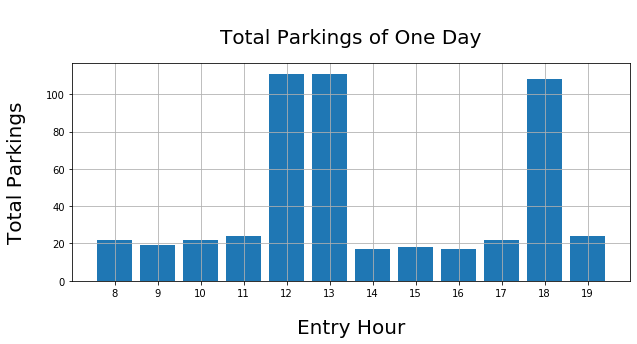

In [86]:
# Query For Specific Day
print("Setting Query for Specific Day and Month...")

df2 = df.copy()
df2 = df2.drop(df2.columns.difference(['timeFrom']), axis=1)

print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

df2 = df2[(df2['timeFrom'].dt.month == 1) & (df2['timeFrom'].dt.day == 6)]

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
#df2 = df2.groupby(pd.Grouper(freq='H', key='timeFrom')).sum().reset_index()

df2 = df2.groupby(df2['timeFrom'].dt.hour).size().reset_index(name='TotalParkings')

print("Done!")
df2

plt.subplots(figsize=(10,4))
plt.grid()
plt.locator_params(axis='x', nbins=24)
plt.bar(df2['timeFrom'],df2['TotalParkings'])

plt.title("\nTotal Parkings of One Day", fontsize=20, pad=20)
plt.xlabel("Entry Hour", fontsize=20, labelpad=20)
plt.ylabel("Total Parkings", fontsize=20, labelpad=20)

plt.figure(1).set_facecolor((1, 1, 1))
plt.show()

In [184]:
dfx = df.copy()
print("Grouping by SpotWon...")

xs = dfx.groupby('spotWon')['timeTo'].nunique().sort_values(ascending=False).reset_index(name='TotalWons')

xs

Grouping by SpotWon...


,spotWon,TotalWons
0,77,6
1,87,6
2,222,5
3,250,5
4,136,5
...,...,...
290,196,1
291,191,1
292,190,1
293,82,1


In [207]:
dfx = df.copy()

wanted_equals_won = [dfx[dfx['spotWon'] == dfx['spotWanted']].count().max()][0]
wanted_dif_won = [dfx[dfx['spotWon'] != dfx['spotWanted']].count().max()][0]

print("Same Spot Wanted & Won: ",wanted_equals_won)
print("Different Spot Wanted & Won: ",wanted_dif_won)

print("\nTotal Parkings: ",wanted_equals_won+wanted_dif_won)
print("Request Sucess Rate: %0.2f%%" % ((wanted_equals_won * 100 / (wanted_equals_won+wanted_dif_won))) )

Same Spot Wanted & Won:  452
Different Spot Wanted & Won:  225

Total Parkings:  677
Request Sucess Rate: 66.77%
